In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
from collections import defaultdict

sns.set(context="paper", style="white", font_scale=2.5, palette="tab10")

# Helpers

In [2]:
def load_results(folder):
    results = defaultdict(lambda: pd.DataFrame())
    for path in folder.glob("**/*.csv"):
        df = pd.read_csv(path, index_col=0)
        subfolder = "" if "domain" in path.parent.name else path.parent.name
        df["subfolder"] = subfolder
        if "toxicity" in path.name:
            if "groupby" in path.name:
                df = pd.read_csv(path, header=[0, 1], index_col=0)
                df = (
                    df.T.reset_index(names=["mode", "domain_result"])
                    .melt(
                        id_vars=["mode", "domain_result"],
                        value_vars=["avg_max", "toxicity_probability", "std_max"],
                        var_name="metric",
                    )
                    .query("metric != 'std_max'")
                )
                df["metric"] = df["metric"].map(
                    {
                        "avg_max": "Expected Maximum Toxicity",
                        "toxicity_probability": "Toxicity Probability",
                    }
                )
                df["subfolder"] = (
                    "" if "domain" in path.parent.name else path.parent.name
                )
                results["toxicity_gb"] = pd.concat([results["toxicity_gb"], df.copy()])
            else:
                df = (
                    df.reset_index()
                    .melt(
                        id_vars=["index", "subfolder"],
                        value_name="value",
                        var_name="mode",
                    )
                    .rename({"index": "metric"}, axis=1)
                    .query("metric != 'std_max'")
                    .copy()
                )

                df["metric"] = df["metric"].map(
                    {
                        "avg_max": "Expected Maximum Toxicity",
                        "toxicity_probability": "Toxicity Probability",
                    }
                )
                results["toxicity"] = pd.concat([results["toxicity"], df.copy()])
        else:
            if "perplexity_groupby" in path.name:
                results["ppl_gb"] = pd.concat([results["ppl_gb"], df.reset_index()])
            elif "diversity_groupby" in path.name:
                results["diversity_gb"] = pd.concat(
                    [results["diversity_gb"], df.reset_index()]
                )
            else:
                df = df.melt(var_name="mode", value_name="value", id_vars=["subfolder"])

                if "perplexity" in path.name:
                    results["ppl"] = pd.concat([results["ppl"], df.copy()])
                elif "diversity" in path.name:
                    results["diversity"] = pd.concat([results["diversity"], df.copy()])

    return results


def get_metrics(exp_path, baseline=False):
    results_dfs = defaultdict(lambda: pd.DataFrame())

    if baseline:
        domain_results = load_results(exp_path)

        for metric, df in domain_results.items():
            # df["subfolder"] = "" if df["subfolder"].iloc[0] != "baseline" else df["subfolder"]
            df["domain"] = "baseline"
            df["domain_idx"] = -1
            results_dfs[metric] = pd.concat(
                [results_dfs[metric], df], axis=0
            ).reset_index(drop=True)

        return results_dfs

    ds_added = [sub.name for sub in exp_path.iterdir()]
    for ds in ds_added:
        # TODO add this ds_added to the dataframe if required
        domains_folders = [
            sub.name
            for sub in sorted((exp_path / ds).iterdir())
            if not "logs" in sub.name
        ]
        for domain_folder in domains_folders:
            idx, domain_name = domain_folder.split("=")[-1].split("-")
            round_path = exp_path / ds / domain_folder

            domain_results = load_results(round_path)

            for metric, df in domain_results.items():
                df["domain"] = domain_name
                df["domain_idx"] = int(idx)
                results_dfs[metric] = pd.concat(
                    [results_dfs[metric], df], axis=0
                ).reset_index(drop=True)

    return results_dfs


def get_experiment_results(experiments, baselines=False, include_subfolder=False):
    metrics_df = defaultdict(lambda: pd.DataFrame())
    for name, path in experiments.items():
        try:
            curr_metrics = get_metrics(path, baselines)
            for metric in curr_metrics.keys():
                curr_metrics[metric]["experiment"] = curr_metrics[metric][
                    "subfolder"
                ].apply(lambda x: f"{name}_{x}" if x else name)
                if not include_subfolder:
                    allowed = ["", "baseline"]
                    curr_metrics[metric] = curr_metrics[metric].query(
                        "subfolder in @allowed"
                    )
                metrics_df[metric] = pd.concat(
                    [metrics_df[metric], curr_metrics[metric]]
                )
        except FileNotFoundError as err:
            print(err)
            pass

    return metrics_df

## Plots

In [3]:
def generate_tables_per_experiment(
    plot_df, baselines_df=None, value_col="value", round=3
):
    groups = plot_df.groupby("experiment")
    tables = {}
    for group, df in groups:
        print(f"Experiment: {group}")

        if baselines_df is not None:
            df = pd.concat([baselines_df, df], axis=0)

        exp_table = (
            pd.pivot_table(
                df.rename(
                    {
                        "domain": "domain_added",
                        "domain_idx": "step",
                        "Domain": "language_metric",
                    },
                    axis=1,
                ),
                values=[value_col],
                index=["domain_added", "step"],
                columns="language_metric",
            )
            .sort_values(by=["step"])
            .droplevel(0, axis=1)[["Overall", *domains.values()]]
        )
        display(exp_table.round(round))
        tables[group] = exp_table.round(round)
    return tables


def generate_tables_per_language(plot_df, value_col="value", round=3):
    ttemp = plot_df.rename(
        {"domain": "domain_added", "domain_idx": "step", "Domain": "language_metric"},
        axis=1,
    )
    ttemp["domain_added"] = ttemp["domain_added"].map(
        {
            "en": "en",
            "ru": "ru",
            "rus": "ru",
            "it": "it",
            "ita": "it",
            "fr": "fr",
            "fra": "fr",
            "pt": "pt",
            "por": "pt",
            "es": "es",
            "spa": "es",
        }
    )

    groups = ttemp.groupby("language_metric")
    for group, df in groups:
        print(f"Language Results: {group}")
        exp_table = (
            pd.pivot_table(
                df,
                values=[value_col],
                index=["domain_added", "step"],
                columns="experiment",
            )
            .sort_values(by=["step"])
            .droplevel(0, axis=1)
        )  # [["Overall", *domains.values()]]
        display(exp_table.round(round))


def plot_overall_cl(
    metric_df, baseline_df, metric, domains, mode="full", savename=None
):
    temp = metric_df.query("mode == @mode and metric == @metric")
    baseline = baseline_df.query("mode == @mode and metric == @metric")
    temp = pd.concat([baseline, temp], axis=0)

    plt.figure(figsize=(7, 4))
    g = sns.pointplot(
        data=temp,
        x="domain_idx",
        y="value",
        linestyles="-",
        hue="experiment",
        scale=2.5,
    )
    plt.grid(axis="y")

    plt.ylabel("Overall EMT")
    plt.xlabel("domain added")
    plt.xticks(
        labels=["Base"] + list(domains.values()),
        ticks=list(range(len(domains) + 1)),
        rotation=45,
    )
    # plt.ylim((0.33, 0.52))
    sns.despine(right=True, top=True)
    sns.move_legend(
        g,
        "upper center",
        ncols=3,
        fontsize=13,
        title="",
        frameon=False,
        bbox_to_anchor=(0.45, 1.25),
    )

    if savename is not None:
        plt.savefig(f"../images/{savename}", format="pdf", bbox_inches="tight")
    plt.show()
    return temp

# All experiments paths

In [4]:
results_folder = Path("../outputs/results").resolve()

cl_experiments = {
    "mGPT (1.3B)": {
        "Hi-res": results_folder / "baseline",
        "Mid-res": results_folder / "baseline/mid_res",
    },
    "mGPT (13B)": {"Mid-res": results_folder / "baseline/original-13B-mid"},
    "Goodtriever": {
        "Native": results_folder
        / "continual_learning/goodtriever-multitask-1.3B/ai-forever/mGPT/knn",
        "Native (inverted)": results_folder
        / "continual_learning/goodtriever-multitask-1.3B/native_inverse/ai-forever/mGPT/knn",
        "Native (3rd order)": results_folder
        / "continual_learning/goodtriever-multitask-1.3B/native_third_order/ai-forever/mGPT/knn",
        "Translated (hi-res)": results_folder
        / "continual_learning/goodtriever-multitask-1.3B/translated/ai-forever/mGPT/knn",
        "Translated (mid-res)": results_folder
        / "continual_learning/goodtriever-multitask-1.3B/translated_mid/ai-forever/mGPT/knn",
        "Translated (mid-res, m2m)": results_folder
        / "continual_learning/goodtriever-multitask-1.3B/translated_mid/m2m_418M/ai-forever/mGPT/knn",
        "Translated (mid-res, nllb 1.3b)": results_folder
        / "continual_learning/goodtriever-multitask-1.3B/translated_mid/nllb_1.3b/ai-forever/mGPT/knn",
        "Translated (mid-res, diff subsets)": results_folder
        / "continual_learning/goodtriever-multitask-1.3B/translated_mid/different_subsets/ai-forever/mGPT/knn",
        "Translated (mid-res, 13B)": results_folder
        / "continual_learning/goodtriever-multitask-13B/translated_mid/ai-forever/mGPT-13B/knn",
    },
    "DExperts": {
        "Native": results_folder
        / "continual_learning/dexperts-multitask-1.3B/fresh_model/ai-forever/mGPT/dexperts",
        "Native (inverted)": results_folder
        / "continual_learning/dexperts-multitask-1.3B/fresh_model/native_inverted/ai-forever/mGPT/dexperts",
        "Native (3rd order)": results_folder
        / "continual_learning/dexperts-multitask-1.3B/native_third_order/ai-forever/mGPT/dexperts",
        "Translated (hi-res)": results_folder
        / "continual_learning/dexperts-multitask-1.3B/fresh_model/translated/ai-forever/mGPT/dexperts",
        "Translated (mid-res)": results_folder
        / "continual_learning/dexperts-multitask-1.3B/fresh_model/translated_mid/ai-forever/mGPT/dexperts",
        "Translated (mid-res, diff subsets)": results_folder
        / "continual_learning/dexperts-multitask-1.3B/translated_mid/different_subsets/ai-forever/mGPT/dexperts",
    },
    "Translation Quality": {
        "Portuguese": results_folder / "single_language/portuguese",
        "Hindi": results_folder / "single_language/hindi",
        "Arabic": results_folder / "single_language/arabic",
        "Russian": results_folder / "single_language/russian",
    },
}

all_languages = {
    "Overall",
    "English",
    "Russian",
    "Italian",
    "French",
    "Portuguese",
    "Spanish",
    "Hindi",
    "Arabic",
    "Korean",
}

MARKERS = [
    ".",
    "o",
    "^",
    "s",
    "D",
    "v",
    "<",
    ">",
    "+",
    "*",
]

base_palette = sns.color_palette("tab10", n_colors=10)
language_palette = {
    lang: color for lang, color in zip(sorted(all_languages), base_palette)
}
markers = {lang: marker for lang, marker in zip(sorted(all_languages), MARKERS)}

## Native vs. Translated

In [5]:
experiments = {
    "Goodtriever": cl_experiments["Goodtriever"]["Native"],
    "Goodtriever (translated)": cl_experiments["Goodtriever"]["Translated (hi-res)"],
    "DExperts": cl_experiments["DExperts"]["Native"],
    "DExperts (translated)": cl_experiments["DExperts"]["Translated (hi-res)"],
}

for name, path in experiments.items():
    assert path.exists(), f"{name} does not exist"

baselines = {
    "mGPT (1.3B)": cl_experiments["mGPT (1.3B)"]["Hi-res"],
}

metrics_df = get_experiment_results(experiments, include_subfolder=False)
baselines_df = get_experiment_results(
    baselines, baselines=True, include_subfolder=False
)

domains = {
    "en": "English",
    "ru": "Russian",
    "it": "Italian",
    "fr": "French",
    "pt-BR": "Portuguese",
    "es": "Spanish",
}

/var/tmp/ipykernel_8105/848695220.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_overall["data type"] = temp_overall["experiment"].apply(
/var/tmp/ipykernel_8105/848695220.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_overall["experiment"] = temp_overall["experiment"].apply(lambda x: x.split(" ")[0])
/var/tmp/ipykernel_8105/848695220.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

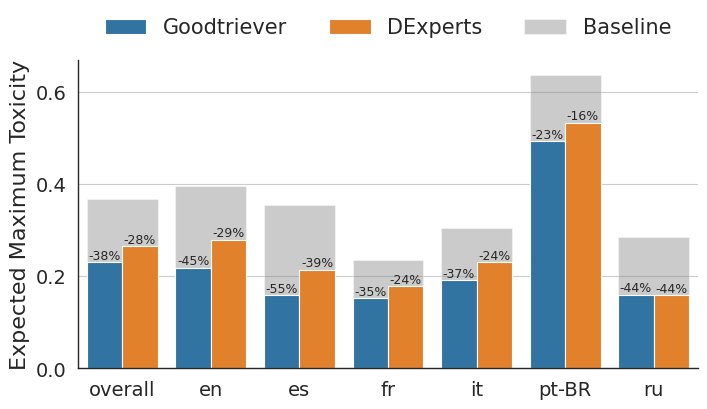

In [6]:
main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"

# Overall
temp_overall = metrics_df["toxicity"].query(
    "domain_idx == 5 and metric in @metric and mode == 'full'"
)
temp_overall["data type"] = temp_overall["experiment"].apply(
    lambda x: "translated" if "translated" in x else "native"
)
temp_overall["experiment"] = temp_overall["experiment"].apply(lambda x: x.split(" ")[0])
temp_overall["domain"] = "overall"

temp_overall = temp_overall[temp_overall["data type"] == "native"]

base_temp_overall = (
    baselines_df["toxicity"].query("metric == @metric and mode == 'full'").copy()
)
base_temp_overall["experiment"] = "baseline"
base_temp_overall["domain"] = "overall"

# Relative values
base_value = base_temp_overall.iloc[0]["value"]
temp_overall["rel_value"] = temp_overall["value"].apply(
    lambda x: (x - base_value) / base_value
)

### Per language
temp = (
    metrics_df[main_metric]
    .query("domain_idx == 5 and metric in @metric and mode == 'full'")
    .reset_index(drop=True)
)
temp["data type"] = temp["experiment"].apply(
    lambda x: "translated" if "translated" in x else "native"
)
temp["experiment"] = temp["experiment"].apply(lambda x: x.split(" ")[0])
temp = temp[temp["data type"] == "native"]

base_temp = (
    baselines_df[main_metric].query("metric == @metric and mode == 'full'").copy()
)
base_temp["experiment"] = "baseline"

# Relative values
groups = temp.groupby("domain_result")
rel_values = pd.Series()
for lang, group in groups:
    base_value = base_temp.query("domain_result == @lang")["value"].iloc[0]
    rel_values = pd.concat(
        [
            rel_values,
            group.apply(lambda x: (x["value"] - base_value) / base_value, axis=1),
        ]
    )

temp.loc[:, "rel_value"] = rel_values.sort_index().values
temp = pd.concat(
    [pd.DataFrame({"domain_result": ["overall"], "rel_value": 0}, index=[0]), temp]
)

plt.figure(figsize=(8, 4))
g = sns.barplot(
    data=base_temp_overall,
    x="domain",
    y="value",
    color="gray",
    label="Baseline",
    alpha=0.4,
)
g = sns.barplot(data=temp_overall, x="domain", y="value", hue="experiment", ax=g)

for i, container in enumerate(g.containers[1:]):
    if i == 0:
        vals = temp_overall.query("experiment == 'Goodtriever'")
    else:
        vals = temp_overall.query("experiment == 'DExperts'")
    vals = vals["rel_value"].apply(lambda x: f"{x:.0%}")
    g.bar_label(container, fontsize=9, labels=vals)

g = sns.barplot(
    data=base_temp,
    x="domain_result",
    y="value",
    color="tab:gray",
    label="Baseline",
    ax=g,
    alpha=0.4,
)
g = sns.barplot(data=temp, x="domain_result", hue="experiment", y="value", ax=g)

for i, container in enumerate(g.containers[-2:]):
    vals = temp.query("domain_result != 'overall'")
    if i == 0:
        vals = vals.query("experiment == 'Goodtriever'")
    else:
        vals = vals.query("experiment == 'DExperts'")

    vals = vals.sort_values(by=["domain_result"])["rel_value"].apply(
        lambda x: f"{x:.0%}"
    )
    g.bar_label(container, fontsize=9, labels=vals)

#### Modify legend
# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()
# add relative emt symbol
# from matplotlib.lines import Line2D
# line = Line2D([0], [0], linestyle="--", color='gray')
# handles.extend([line])
# labels.extend(['relative EMT'])
# remove duplicated elements
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
sns.move_legend(
    g,
    "upper center",
    ncols=3,
    fontsize=15,
    frameon=False,
    bbox_to_anchor=(0.5, 1.2),
    title="",
)
sns.despine()
plt.ylabel(metric, fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=14)
plt.grid(axis="y")

# sns.despine(top=True, right=False)
plt.savefig("../images/in-language_emt.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../images/in-language_emt.svg", format="svg", bbox_inches="tight")
plt.show()

/var/tmp/ipykernel_8105/2070903039.py:24: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  g = sns.barplot(


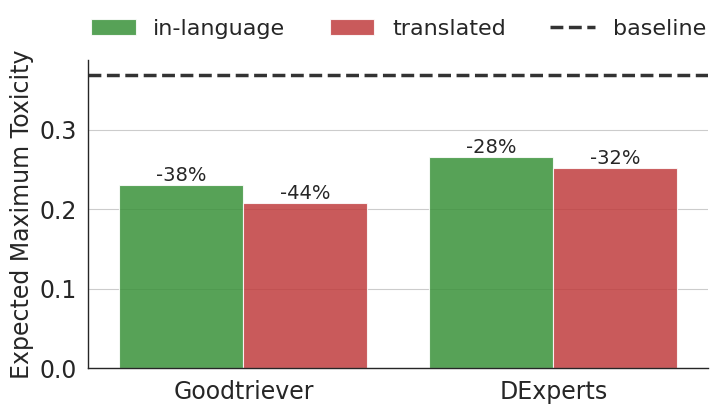

In [7]:
main_metric = "toxicity"
metric = "Expected Maximum Toxicity"

temp = (
    metrics_df[main_metric]
    .query("domain_idx == 5 and metric in @metric and mode == 'full'")
    .reset_index(drop=True)
)
temp["data type"] = temp["experiment"].apply(
    lambda x: "translated" if "translated" in x else "in-language"
)
temp["experiment"] = temp["experiment"].apply(lambda x: x.split(" ")[0])

base_temp = (
    baselines_df[main_metric].query("metric == @metric and mode == 'full'").copy()
)
base_temp["experiment"] = "mGPT (1.3B)"

base_value = base_temp.iloc[0]["value"]
temp["rel_value"] = temp["value"].apply(lambda x: (x - base_value) / base_value)

plt.figure(figsize=(8, 4))
palette = sns.color_palette("tab10")[2:]
g = sns.barplot(
    data=temp, x="experiment", y="value", hue="data type", palette=palette, alpha=0.85
)
# g = sns.barplot(data=temp, x="experiment", y="rel_value", hue="data type")

for i, container in enumerate(g.containers):
    if i == 0:
        vals = temp[temp["data type"] == "in-language"]
    else:
        vals = temp[temp["data type"] == "translated"]

    vals = vals["rel_value"].apply(lambda x: f"{x:.0%}").values
    g.bar_label(container, fontsize=14, labels=vals)

g.axhline(
    y=base_temp.query("experiment == 'mGPT (1.3B)'")["value"].values[0],
    color="black",
    linestyle="--",
    label="baseline",
    linewidth=2.5,
    alpha=0.8,
)
plt.legend()

sns.despine(right=True, top=True)
sns.move_legend(
    g,
    "upper center",
    ncols=3,
    fontsize=16,
    frameon=False,
    bbox_to_anchor=(0.5, 1.2),
)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.ylabel(metric, fontsize=17)
plt.xlabel("")
plt.grid(axis="y")
plt.savefig(
    "../images/native_translated_overall_emt.pdf", format="pdf", bbox_inches="tight"
)
plt.show()

In [8]:
## RELATIVE plot

main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"
# metric = "Toxicity Probability"
mode = "full"

baseline = baselines_df[main_metric].query("mode == @mode and metric == @metric")

temp = (
    metrics_df[main_metric]
    .query("mode == @mode and metric == @metric")
    .reset_index(drop=True)
)

# Relative values
groups = temp.groupby("domain_result")
rel_values = pd.Series()
for lang, group in groups:
    base_value = baseline.query("domain_result == @lang")["value"].iloc[0]
    rel_values = pd.concat(
        [
            rel_values,
            group.apply(lambda x: (x["value"] - base_value) / base_value, axis=1),
        ]
    )

temp.loc[:, "rel_value"] = rel_values.sort_index().values
temp["Domain"] = temp["domain_result"].map({**domains})

overall = metrics_df["toxicity"].query("mode == @mode and metric == @metric").copy()
baseline_overall = (
    baselines_df["toxicity"].query("mode == @mode and metric == @metric").copy()
)
overall.loc[:, "rel_value"] = (
    overall["value"] - baseline_overall["value"].iloc[0]
) / baseline_overall["value"].iloc[0]
overall["Domain"] = "Overall"

temp = pd.concat([overall, temp])

temp["model"] = temp["experiment"].apply(lambda x: x.split(" ")[0])
temp["type"] = temp["experiment"].apply(
    lambda x: "translated" if "translated" in x else "native"
)

selected = ["French", "Italian", "Russian"]

baseline.loc[:, "Domain"] = baseline["domain_result"].map({**domains})
baseline_overall["Domain"] = "Overall"
all_baselines = pd.concat([baseline, baseline_overall])

tables = generate_tables_per_experiment(
    temp, baselines_df=all_baselines, value_col="rel_value", round=2
)

Experiment: DExperts


/var/tmp/ipykernel_8105/1822260086.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline.loc[:, "Domain"] = baseline["domain_result"].map({**domains})


,language_metric,Overall,English,Russian,Italian,French,Portuguese,Spanish
domain_added,step,,,,,,,
en,0,-0.16,-0.22,-0.14,-0.14,-0.17,-0.11,-0.20
ru,1,-0.20,-0.29,-0.36,-0.12,-0.21,-0.12,-0.21
it,2,-0.21,-0.31,-0.42,-0.15,-0.15,-0.13,-0.15
fr,3,-0.23,-0.31,-0.44,-0.23,-0.24,-0.09,-0.19
pt,4,-0.24,-0.28,-0.47,-0.21,-0.19,-0.16,-0.22
es,5,-0.28,-0.29,-0.44,-0.24,-0.24,-0.16,-0.39


Experiment: DExperts (translated)


,language_metric,Overall,English,Russian,Italian,French,Portuguese,Spanish
domain_added,step,,,,,,,
en,0,-0.15,-0.21,-0.12,-0.13,-0.17,-0.11,-0.19
rus,1,-0.20,-0.27,-0.25,-0.12,-0.26,-0.11,-0.24
ita,2,-0.24,-0.31,-0.31,-0.30,-0.23,-0.14,-0.21
fra,3,-0.25,-0.28,-0.33,-0.33,-0.28,-0.15,-0.29
por,4,-0.30,-0.30,-0.33,-0.30,-0.29,-0.27,-0.31
spa,5,-0.32,-0.29,-0.38,-0.33,-0.29,-0.27,-0.37


Experiment: Goodtriever


,language_metric,Overall,English,Russian,Italian,French,Portuguese,Spanish
domain_added,step,,,,,,,
en,0,-0.12,-0.44,0.00,-0.10,-0.05,-0.02,-0.08
ru,1,-0.19,-0.48,-0.42,-0.12,-0.07,-0.04,-0.07
it,2,-0.22,-0.47,-0.47,-0.30,-0.11,-0.03,-0.07
fr,3,-0.23,-0.45,-0.41,-0.35,-0.34,-0.01,-0.10
pt,4,-0.29,-0.46,-0.50,-0.33,-0.37,-0.15,-0.11
es,5,-0.38,-0.45,-0.44,-0.37,-0.35,-0.23,-0.55


Experiment: Goodtriever (translated)


,language_metric,Overall,English,Russian,Italian,French,Portuguese,Spanish
domain_added,step,,,,,,,
en,0,-0.10,-0.37,-0.08,-0.06,-0.07,-0.02,-0.01
rus,1,-0.16,-0.40,-0.50,-0.06,-0.08,-0.05,0.02
ita,2,-0.24,-0.45,-0.46,-0.47,-0.09,-0.05,-0.07
fra,3,-0.28,-0.44,-0.52,-0.44,-0.50,-0.06,-0.03
por,4,-0.40,-0.44,-0.47,-0.43,-0.49,-0.40,-0.23
spa,5,-0.44,-0.42,-0.45,-0.43,-0.51,-0.36,-0.52


In [9]:
# Cross lingual transfer: avg mitigation on languages not added at that timestep
import numpy as np

cross_lingual_efct = dict()
for name, table in tables.items():
    table = table.reset_index()
    table["domain_added"] = table["domain_added"].map(
        {
            np.nan: "Overall",
            "en": "en",
            "ru": "ru",
            "rus": "ru",
            "it": "it",
            "ita": "it",
            "fr": "fr",
            "fra": "fr",
            "pt": "pt",
            "por": "pt",
            "es": "es",
            "spa": "es",
        }
    )
    table = table.set_index(["domain_added", "step"])
    cross_lingual_efct[name] = (
        table.rolling(2)
        .apply(lambda x: x[0] - x[1])
        .drop("Overall", axis=1)
        .apply(lambda x: (x.sum() - x[x.name[1]]).mean(), axis=1)
    )

cross_lingual_efct = pd.DataFrame(cross_lingual_efct).round(3).dropna()
cross_lingual_efct

,,DExperts,DExperts (translated),Goodtriever,Goodtriever (translated)
domain_added,step,,,,
ru,1,0.11,0.19,0.09,0.04
it,2,-0.03,0.07,0.07,0.11
fr,3,0.10,0.11,-0.02,-0.01
pt,4,-0.04,0.02,0.12,0.13
es,5,0.06,0.07,0.03,-0.06


### Native - Inverted order

In [10]:
experiments = {
    "Goodtriever": cl_experiments["Goodtriever"]["Native"],
    "Goodtriever (other order)": cl_experiments["Goodtriever"]["Native (3rd order)"],
    "DExperts": cl_experiments["DExperts"]["Native"],
    "DExperts (other order)": cl_experiments["DExperts"]["Native (3rd order)"],
}

for name, path in experiments.items():
    assert path.exists(), f"{name} does not exist"

baselines = {
    "mGPT (1.3B)": cl_experiments["mGPT (1.3B)"]["Hi-res"],
}

metrics_df = get_experiment_results(experiments, include_subfolder=False)
baselines_df = get_experiment_results(
    baselines, baselines=True, include_subfolder=False
)

domains = {
    "en": "English",
    "ru": "Russian",
    "it": "Italian",
    "fr": "French",
    "pt-BR": "Portuguese",
    "es": "Spanish",
}

In [11]:
## RELATIVE plot

main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"
# metric = "Toxicity Probability"
mode = "full"

baseline = baselines_df[main_metric].query("mode == @mode and metric == @metric")
overall = metrics_df["toxicity"].query("mode == @mode and metric == @metric").copy()
overall["domain_result"] = "Overall"

temp = (
    metrics_df[main_metric]
    .query("mode == @mode and metric == @metric")
    .reset_index(drop=True)
)
baseline = baselines_df[main_metric].query("mode == @mode and metric == @metric")

# Relative values
groups = temp.groupby("domain_result")
rel_values = pd.Series()
for lang, group in groups:
    base_value = baseline.query("domain_result == @lang")["value"].iloc[0]
    rel_values = pd.concat(
        [
            rel_values,
            group.apply(lambda x: (x["value"] - base_value) / base_value, axis=1),
        ]
    )

temp.loc[:, "rel_value"] = rel_values.sort_index().values
temp["Domain"] = temp["domain_result"].map({**domains})

overall = metrics_df["toxicity"].query("mode == @mode and metric == @metric").copy()
baseline_overall = (
    baselines_df["toxicity"].query("mode == @mode and metric == @metric").copy()
)
overall.loc[:, "rel_value"] = (
    overall["value"] - baseline_overall["value"].iloc[0]
) / baseline_overall["value"].iloc[0]
overall["Domain"] = "Overall"

temp = pd.concat([overall, temp]).reset_index(drop=True)

baseline.loc[:, "Domain"] = baseline["domain_result"].map({**domains})
baseline_overall["Domain"] = "Overall"
all_baselines = pd.concat([baseline, baseline_overall])

print("Results at last step for each model: ")
last_step = pd.pivot_table(
    temp.query("domain_idx == 5"),
    values="value",
    index="experiment",
    columns="Domain",
).round(3)
display(last_step)

baseline.loc[:, "Domain"] = baseline["domain_result"].map({**domains})
baseline_overall["Domain"] = "Overall"
all_baselines = pd.concat([baseline, baseline_overall])

tables = generate_tables_per_experiment(
    temp, baselines_df=all_baselines, value_col="value", round=2
)

Results at last step for each model: 


/var/tmp/ipykernel_8105/526205330.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline.loc[:, "Domain"] = baseline["domain_result"].map({**domains})


Domain,English,French,Italian,Overall,Portuguese,Russian,Spanish
experiment,,,,,,,
DExperts,0.279,0.179,0.230,0.266,0.533,0.159,0.215
DExperts (other order),0.172,0.089,0.128,0.169,0.393,0.113,0.119
Goodtriever,0.219,0.152,0.191,0.230,0.493,0.160,0.159
Goodtriever (other order),0.228,0.139,0.241,0.256,0.607,0.164,0.158


Experiment: DExperts


,language_metric,Overall,English,Russian,Italian,French,Portuguese,Spanish
domain_added,step,,,,,,,
baseline,-1,0.37,0.40,0.29,0.30,0.24,0.64,0.35
en,0,0.31,0.31,0.24,0.26,0.19,0.57,0.28
ru,1,0.29,0.28,0.18,0.27,0.19,0.56,0.28
it,2,0.29,0.27,0.17,0.26,0.20,0.55,0.30
fr,3,0.28,0.27,0.16,0.23,0.18,0.58,0.29
pt,4,0.28,0.28,0.15,0.24,0.19,0.53,0.27
es,5,0.27,0.28,0.16,0.23,0.18,0.53,0.21


Experiment: DExperts (other order)


,language_metric,Overall,English,Russian,Italian,French,Portuguese,Spanish
domain_added,step,,,,,,,
baseline,-1,0.37,0.40,0.29,0.30,0.24,0.64,0.35
fr,0,0.31,0.31,0.18,0.26,0.16,0.61,0.33
pt,1,0.28,0.31,0.11,0.27,0.15,0.55,0.27
en,2,0.24,0.21,0.08,0.26,0.14,0.49,0.24
it,3,0.23,0.20,0.09,0.22,0.15,0.50,0.20
es,4,0.20,0.20,0.10,0.16,0.12,0.47,0.12
ru,5,0.17,0.17,0.11,0.13,0.09,0.39,0.12


Experiment: Goodtriever


,language_metric,Overall,English,Russian,Italian,French,Portuguese,Spanish
domain_added,step,,,,,,,
baseline,-1,0.37,0.40,0.29,0.30,0.24,0.64,0.35
en,0,0.33,0.22,0.29,0.27,0.22,0.62,0.33
ru,1,0.30,0.21,0.16,0.27,0.22,0.61,0.33
it,2,0.29,0.21,0.15,0.21,0.21,0.62,0.33
fr,3,0.28,0.22,0.17,0.20,0.16,0.63,0.32
pt,4,0.26,0.21,0.14,0.20,0.15,0.54,0.32
es,5,0.23,0.22,0.16,0.19,0.15,0.49,0.16


Experiment: Goodtriever (other order)


,language_metric,Overall,English,Russian,Italian,French,Portuguese,Spanish
domain_added,step,,,,,,,
baseline,-1,0.37,0.40,0.29,0.30,0.24,0.64,0.35
fr,0,0.32,0.32,0.24,0.26,0.14,0.63,0.36
pt,1,0.33,0.39,0.23,0.29,0.14,0.60,0.35
en,2,0.30,0.21,0.25,0.29,0.13,0.59,0.35
it,3,0.30,0.21,0.26,0.24,0.14,0.59,0.35
es,4,0.27,0.22,0.26,0.23,0.13,0.61,0.16
ru,5,0.26,0.23,0.16,0.24,0.14,0.61,0.16


(experiment
 DExperts       0.10
 Goodtriever   -0.03
 dtype: float64,
 experiment
 DExperts       0.03
 Goodtriever    0.04
 dtype: float64)

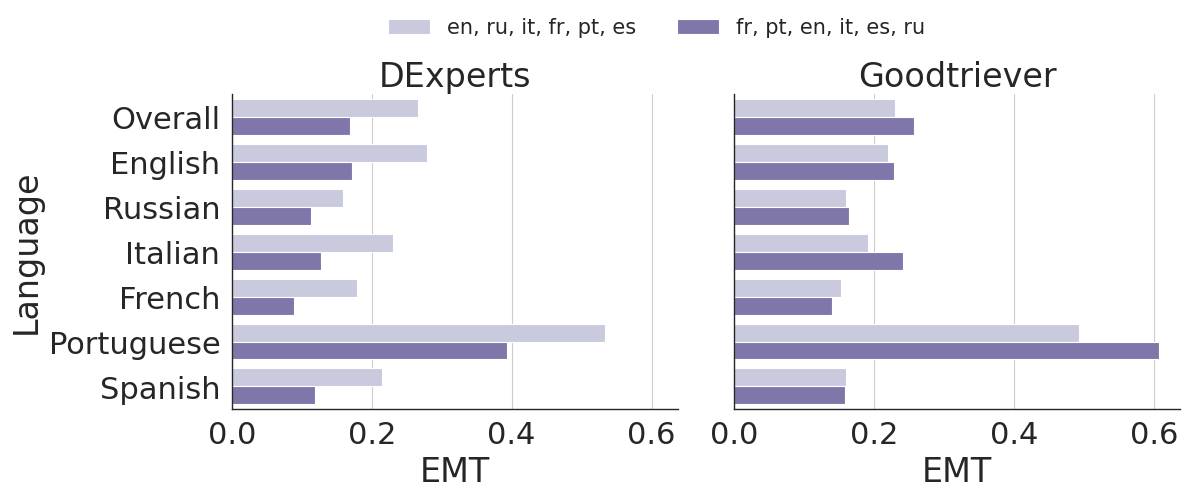

In [12]:
temp = last_step.reset_index()
temp["order"] = (
    temp["experiment"]
    .str.contains("other")
    .map({False: "en, ru, it, fr, pt, es", True: "fr, pt, en, it, es, ru"})
)
temp["experiment"] = temp["experiment"].apply(lambda x: x.split(" ")[0])
temp = temp.melt(id_vars=["experiment", "order"], var_name="Language", value_name="EMT")
# plt.figure(figsize=(8, 4))
# with sns.plotting_context(font_scale=0.2):
g = sns.catplot(
    data=temp,
    y="Language",
    x="EMT",
    col="experiment",
    hue="order",
    kind="bar",
    order=["Overall", *domains.values()],
    height=5,
    aspect=1.3,
    palette="Purples",
)
g.set_titles("{col_name}")
# turn on grid
for ax in g.axes.flatten():
    ax.grid(axis="x")

sns.move_legend(
    g, "upper center", bbox_to_anchor=(0.45, 1.05), ncol=2, fontsize=15, title=""
)
plt.savefig(
    "../images/highres_domain_order_last_step.pdf", format="pdf", bbox_inches="tight"
)
plt.savefig(
    "../images/highres_domain_order_last_step.svg", format="svg", bbox_inches="tight"
)

# Average and std of EMT change for each model
emt_var = temp.groupby(["experiment", "Language"]).apply(
    lambda x: x["EMT"].iloc[0] - x["EMT"].iloc[1]
)
emt_var.groupby("experiment").mean().round(2), emt_var.groupby(
    "experiment"
).std().round(2)

In [13]:
# Cross lingual transfer: avg mitigation on languages not added at that timestep
cross_lingual_efct = defaultdict(lambda: pd.DataFrame())
for name, table in tables.items():
    order = name.split(" ")[-1]
    if "order" in order:
        order_name = "other order"
    else:
        order_name = "base order"

    cross_lingual_df = (
        table.rolling(2)
        .apply(lambda x: x[0] - x[1])
        .drop("Overall", axis=1)
        .apply(lambda x: (x.sum() - x[x.name[1]]).mean(), axis=1)
    ).to_frame(name=name)
    cross_lingual_efct[order_name] = pd.concat(
        [cross_lingual_efct[order_name], cross_lingual_df], axis=1
    )

for order_name in cross_lingual_efct.keys():
    print(f"Cross lingual effect for {order_name}")
    display(cross_lingual_efct[order_name].round(3).dropna())

Cross lingual effect for base order


,,DExperts,Goodtriever
domain_added,step,,
en,0,0.28,0.09
ru,1,0.03,0.02
it,2,0.00,0.01
fr,3,0.02,-0.02
pt,4,-0.00,0.05
es,5,0.01,0.03


Cross lingual effect for other order


,,DExperts (other order),Goodtriever (other order)
domain_added,step,,
fr,0,0.28,0.19
pt,1,0.12,-0.06
en,2,0.23,0.18
it,3,0.07,0.04
es,4,0.16,0.20
ru,5,0.16,0.07


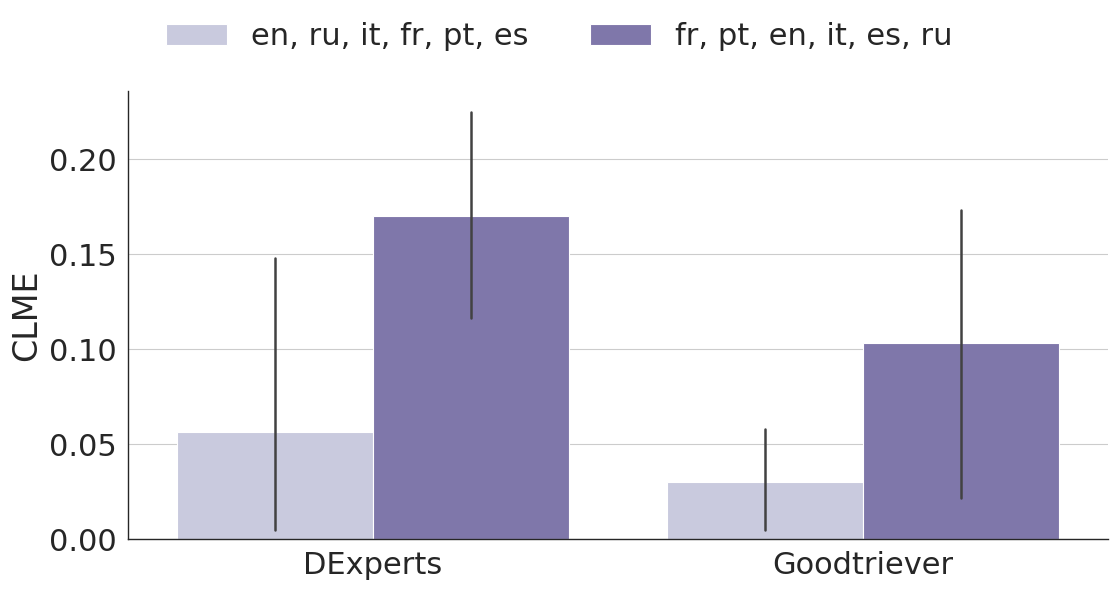

In [9]:
to_plot = pd.DataFrame()
for name, df in cross_lingual_efct.items():
    temp = (
        df.reset_index()
        .dropna()
        .melt(id_vars=["domain_added", "step"], value_name="CLME")
    )
    temp["variable"] = temp["variable"].apply(lambda x: x.split(" ")[0])
    temp["order"] = name
    to_plot = pd.concat([to_plot, temp])

to_plot["order"] = to_plot["order"].map(
    {"base order": "en, ru, it, fr, pt, es", "other order": "fr, pt, en, it, es, ru"}
)
g = sns.catplot(
    data=to_plot,
    x="variable",
    y="CLME",
    hue="order",
    kind="bar",
    height=6,
    aspect=2,
    palette="Purples",
)
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.grid(axis="y")
    ax.set_xlabel("")
sns.move_legend(g, "upper center", bbox_to_anchor=(0.4, 1.1), ncol=2, title="")
plt.savefig("../images/native_domain_order_clme.pdf", format="pdf", bbox_inches="tight")

## Mid-resource

In [14]:
# Mid resource languages
experiments = {
    "Goodtriever": cl_experiments["Goodtriever"]["Translated (mid-res)"],
    "DExperts": cl_experiments["DExperts"]["Translated (mid-res)"],
}

for name, path in experiments.items():
    assert path.exists(), f"{name} does not exist"

baselines = {
    "mGPT (1.3B)": cl_experiments["mGPT (1.3B)"]["Mid-res"],
}

metrics_df = get_experiment_results(experiments, include_subfolder=False)
baselines_df = get_experiment_results(baselines, baselines=True, include_subfolder=True)

domains = {
    "ar": "Arabic",
    "ko": "Korean",
    "hi": "Hindi",
    "pt-BR": "Portuguese",
    "ru": "Russian",
    "en": "English",
}

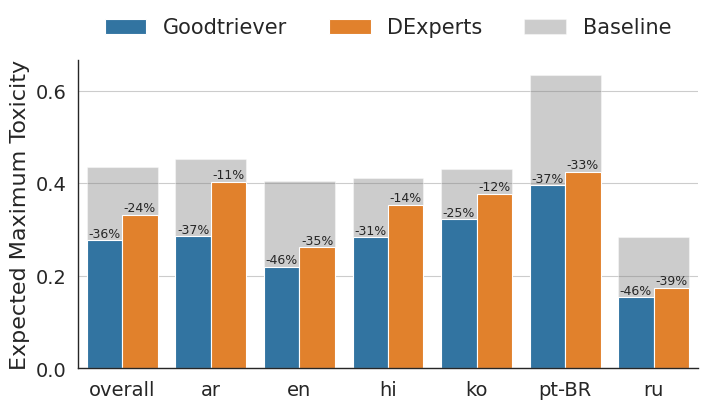

In [15]:
main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"

# Overall
temp_overall = (
    metrics_df["toxicity"]
    .query("domain_idx == 5 and metric in @metric and mode == 'full'")
    .copy()
)
temp_overall["experiment"] = temp_overall["experiment"].apply(lambda x: x.split(" ")[0])
temp_overall["domain"] = "overall"

base_temp_overall = (
    baselines_df["toxicity"].query("metric == @metric and mode == 'full'").copy()
).copy()
base_temp_overall["experiment"] = "mGPT (1.3B)"
base_temp_overall["domain"] = "overall"

# Relative values
base_value = base_temp_overall.iloc[0]["value"]
temp_overall["rel_value"] = temp_overall["value"].apply(
    lambda x: (x - base_value) / base_value
)

### Per language
temp = (
    metrics_df[main_metric]
    .query("domain_idx == 5 and metric in @metric and mode == 'full'")
    .reset_index(drop=True)
).copy()
temp["experiment"] = temp["experiment"].apply(lambda x: x.split(" ")[0])

base_temp = (
    baselines_df[main_metric].query("metric == @metric and mode == 'full'").copy()
).copy()
base_temp["experiment"] = "mGPT (1.3B)"

# Relative values
groups = temp.groupby("domain_result")
rel_values = pd.Series()
for lang, group in groups:
    base_value = base_temp.query("domain_result == @lang")["value"].iloc[0]
    rel_values = pd.concat(
        [
            rel_values,
            group.apply(lambda x: (x["value"] - base_value) / base_value, axis=1),
        ]
    )

temp.loc[:, "rel_value"] = rel_values.sort_index().values
temp = pd.concat(
    [pd.DataFrame({"domain_result": ["overall"], "rel_value": 0}, index=[0]), temp]
)

plt.figure(figsize=(8, 4))
g = sns.barplot(
    data=base_temp_overall,
    x="domain",
    y="value",
    color="gray",
    label="Baseline",
    alpha=0.4,
)
g = sns.barplot(data=temp_overall, x="domain", y="value", hue="experiment", ax=g)

for i, container in enumerate(g.containers[1:]):
    if i == 0:
        vals = temp_overall.query("experiment == 'Goodtriever'")
    else:
        vals = temp_overall.query("experiment == 'DExperts'")
    vals = vals["rel_value"].apply(lambda x: f"{x:.0%}")
    g.bar_label(container, fontsize=9, labels=vals)

g = sns.barplot(
    data=base_temp,
    x="domain_result",
    y="value",
    color="gray",
    label="Baseline",
    alpha=0.4,
    ax=g,
)
g = sns.barplot(data=temp, x="domain_result", hue="experiment", y="value", ax=g)

for i, container in enumerate(g.containers[-2:]):
    vals = temp.query("domain_result != 'overall'")
    if i == 0:
        vals = vals.query("experiment == 'Goodtriever'")
    else:
        vals = vals.query("experiment == 'DExperts'")

    vals = vals.sort_values(by=["domain_result"])["rel_value"].apply(
        lambda x: f"{x:.0%}"
    )
    g.bar_label(container, fontsize=9, labels=vals)

#### Modify legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
sns.move_legend(
    g,
    "upper center",
    ncols=3,
    fontsize=15,
    frameon=False,
    bbox_to_anchor=(0.5, 1.2),
    title="",
)
sns.despine()
plt.ylabel(metric, fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("")
plt.grid(axis="y")
plt.savefig("../images/mid-res_emt.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../images/mid-res_emt.svg", format="svg", bbox_inches="tight")
plt.show()

## Mid-resource - different subsets on datastore for each language

In [22]:
# Mid resource languages

experiments = {
    "Goodtriever (parallel)": cl_experiments["Goodtriever"]["Translated (mid-res)"],
    "Goodtriever (unparallel)": cl_experiments["Goodtriever"][
        "Translated (mid-res, diff subsets)"
    ],
    "DExperts (parallel)": cl_experiments["DExperts"]["Translated (mid-res)"],
    "DExperts (unparallel)": cl_experiments["DExperts"][
        "Translated (mid-res, diff subsets)"
    ],
}

for name, path in experiments.items():
    assert path.exists(), f"{name} does not exist"

baselines = {
    "mGPT (1.3B)": cl_experiments["mGPT (1.3B)"]["Mid-res"],
}

metrics_df = get_experiment_results(experiments, include_subfolder=False)
baselines_df = get_experiment_results(baselines, baselines=True, include_subfolder=True)

domains = {
    "ar": "Arabic",
    "ko": "Korean",
    "hi": "Hindi",
    "pt-BR": "Portuguese",
    "ru": "Russian",
    "en": "English",
}

<Figure size 600x400 with 0 Axes>

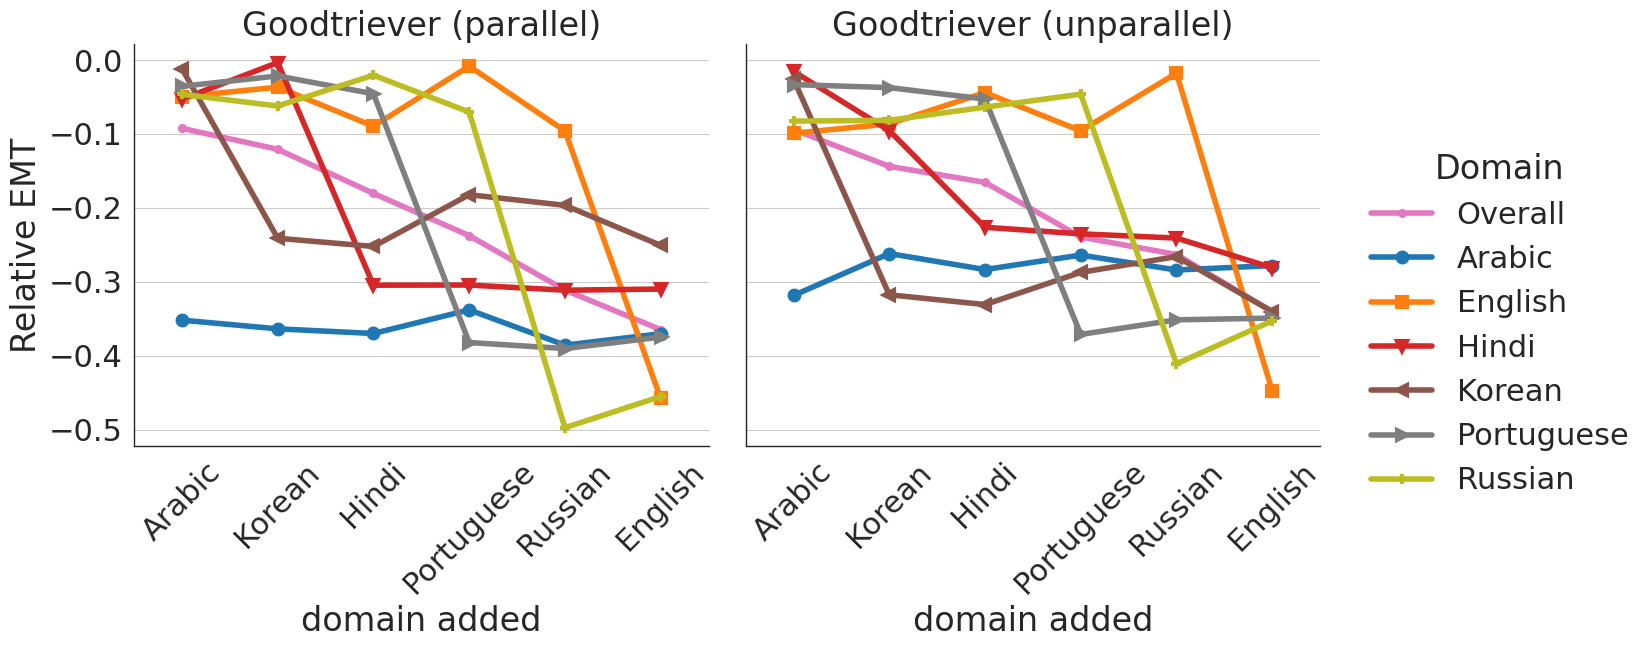

<Figure size 600x400 with 0 Axes>

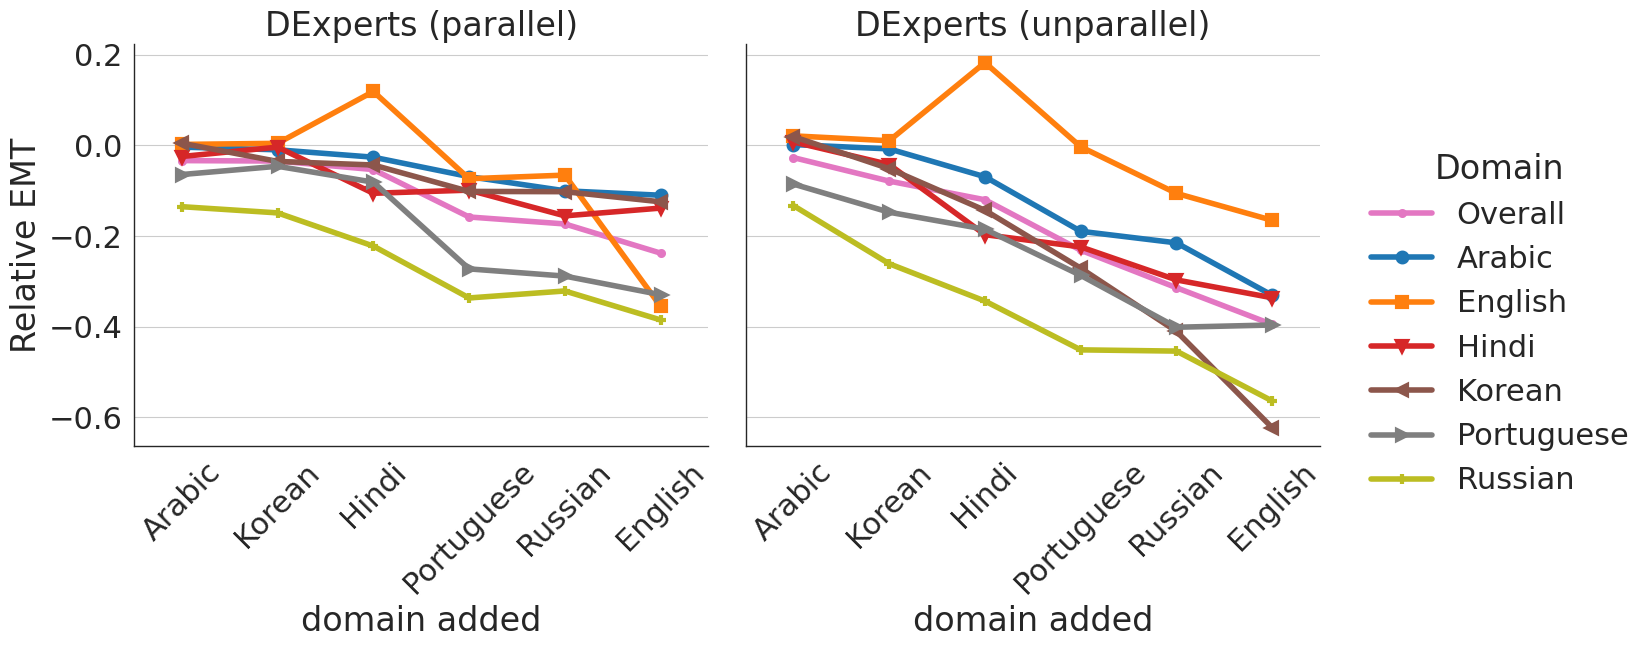

Experiment: DExperts (parallel)


/var/tmp/ipykernel_8105/2811839802.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline.loc[:, "Domain"] = baseline["domain_result"].map({**domains})


,language_metric,Overall,Arabic,Korean,Hindi,Portuguese,Russian,English
domain_added,step,,,,,,,
arb,0,-0.03,-0.00,0.00,-0.02,-0.06,-0.14,0.00
kor,1,-0.03,-0.01,-0.04,-0.00,-0.05,-0.15,0.00
hin,2,-0.05,-0.03,-0.04,-0.11,-0.08,-0.22,0.12
por,3,-0.16,-0.07,-0.10,-0.10,-0.27,-0.34,-0.07
rus,4,-0.17,-0.10,-0.10,-0.16,-0.29,-0.32,-0.07
en,5,-0.24,-0.11,-0.12,-0.14,-0.33,-0.39,-0.35


Experiment: DExperts (unparallel)


,language_metric,Overall,Arabic,Korean,Hindi,Portuguese,Russian,English
domain_added,step,,,,,,,
arb,0,-0.03,0.00,0.02,0.01,-0.09,-0.13,0.02
kor,1,-0.08,-0.01,-0.05,-0.04,-0.15,-0.26,0.01
hin,2,-0.12,-0.07,-0.14,-0.20,-0.18,-0.34,0.18
por,3,-0.23,-0.19,-0.27,-0.22,-0.29,-0.45,-0.00
rus,4,-0.31,-0.21,-0.41,-0.30,-0.40,-0.45,-0.11
en,5,-0.40,-0.33,-0.62,-0.34,-0.40,-0.56,-0.17


Experiment: Goodtriever (parallel)


,language_metric,Overall,Arabic,Korean,Hindi,Portuguese,Russian,English
domain_added,step,,,,,,,
arb,0,-0.09,-0.35,-0.01,-0.05,-0.04,-0.05,-0.05
kor,1,-0.12,-0.36,-0.24,-0.00,-0.02,-0.06,-0.04
hin,2,-0.18,-0.37,-0.25,-0.30,-0.05,-0.02,-0.09
por,3,-0.24,-0.34,-0.18,-0.30,-0.38,-0.07,-0.01
rus,4,-0.31,-0.39,-0.20,-0.31,-0.39,-0.50,-0.10
en,5,-0.36,-0.37,-0.25,-0.31,-0.37,-0.46,-0.46


Experiment: Goodtriever (unparallel)


,language_metric,Overall,Arabic,Korean,Hindi,Portuguese,Russian,English
domain_added,step,,,,,,,
arb,0,-0.09,-0.32,-0.03,-0.02,-0.03,-0.08,-0.10
kor,1,-0.14,-0.26,-0.32,-0.10,-0.04,-0.08,-0.09
hin,2,-0.17,-0.28,-0.33,-0.23,-0.05,-0.06,-0.04
por,3,-0.24,-0.26,-0.29,-0.24,-0.37,-0.05,-0.10
rus,4,-0.26,-0.28,-0.27,-0.24,-0.35,-0.41,-0.02
en,5,-0.34,-0.28,-0.34,-0.28,-0.35,-0.35,-0.45


[DExperts (parallel)] Average result for English, Russian, Portuguese: -0.36
[DExperts (parallel)] Average result for Arabic, Korean, Hindi: -0.12
[DExperts (unparallel)] Average result for English, Russian, Portuguese: -0.38
[DExperts (unparallel)] Average result for Arabic, Korean, Hindi: -0.43
[Goodtriever (parallel)] Average result for English, Russian, Portuguese: -0.43
[Goodtriever (parallel)] Average result for Arabic, Korean, Hindi: -0.31
[Goodtriever (unparallel)] Average result for English, Russian, Portuguese: -0.38
[Goodtriever (unparallel)] Average result for Arabic, Korean, Hindi: -0.3


In [23]:
## RELATIVE plot

main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"
# metric = "Toxicity Probability"
mode = "full"

baseline = baselines_df[main_metric].query("mode == @mode and metric == @metric")
overall = metrics_df["toxicity"].query("mode == @mode and metric == @metric").copy()
overall["domain_result"] = "Overall"

temp = (
    metrics_df[main_metric]
    .query("mode == @mode and metric == @metric")
    .reset_index(drop=True)
)
baseline = baselines_df[main_metric].query("mode == @mode and metric == @metric")

# Relative values
groups = temp.groupby("domain_result")
rel_values = pd.Series()
for lang, group in groups:
    base_value = baseline.query("domain_result == @lang")["value"].iloc[0]
    rel_values = pd.concat(
        [
            rel_values,
            group.apply(lambda x: (x["value"] - base_value) / base_value, axis=1),
        ]
    )

temp.loc[:, "rel_value"] = rel_values.sort_index().values
temp["Domain"] = temp["domain_result"].map({**domains})

overall = metrics_df["toxicity"].query("mode == @mode and metric == @metric").copy()
baseline_overall = (
    baselines_df["toxicity"].query("mode == @mode and metric == @metric").copy()
)
overall.loc[:, "rel_value"] = (
    overall["value"] - baseline_overall["value"].iloc[0]
) / baseline_overall["value"].iloc[0]
overall["Domain"] = "Overall"

temp = pd.concat([overall, temp]).reset_index(drop=True)

for model in ["Goodtriever", "DExperts"]:
    temp2 = temp[temp.experiment.str.contains(model)]
    plt.figure(figsize=(6, 4))
    g = sns.catplot(
        data=temp2,
        x="domain_idx",
        y="rel_value",
        kind="point",
        hue="Domain",
        col="experiment",
        height=7,
        aspect=1.0,
        col_wrap=2,
        palette=language_palette,
        linewidth=4,
        markersize=7,
        markers=[m for l, m in markers.items() if l in temp["Domain"].unique()],
    )
    g.set_titles("{col_name}")
    for ax, domain in zip(g.axes.flatten(), temp["Domain"].unique()):
        ax.set_xticks(
            labels=list(domains.values()), ticks=range(len(domains)), rotation=45
        )
        ax.set_xlabel("domain added")
        ax.set_ylabel(f"Relative EMT")
        ax.grid(axis="y")

    g.tight_layout()
    sns.move_legend(g, "center right", bbox_to_anchor=(1.0, 0.5))
    plt.savefig(
        f"../images/parallel_vs_unparallel_{model}.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.savefig(
        f"../images/parallel_vs_unparallel_{model}.svg",
        format="svg",
        bbox_inches="tight",
    )
    plt.show()

baseline.loc[:, "Domain"] = baseline["domain_result"].map({**domains})
baseline_overall["Domain"] = "Overall"
all_baselines = pd.concat([baseline, baseline_overall])

tables = generate_tables_per_experiment(
    temp, baselines_df=all_baselines, value_col="rel_value", round=2
)

for model, table in tables.items():
    for resources in [
        ["English", "Russian", "Portuguese"],
        ["Arabic", "Korean", "Hindi"],
    ]:
        results = table[resources]
        print(
            f"[{model}] Average result for {', '.join(resources)}: {results.iloc[-1].mean().round(2)}"
        )

In [24]:
# Cross lingual transfer: avg mitigation on languages not added at that timestep

cross_lingual_efct = dict()
for name, table in tables.items():
    cross_lingual_efct[name] = (
        table.rolling(2)
        .apply(lambda x: x[0] - x[1])
        .drop("Overall", axis=1)
        .apply(lambda x: (x.sum() - x[x.name[1]]).mean(), axis=1)
    )

cross_lingual_efct = pd.DataFrame(cross_lingual_efct).round(3).dropna()
display(cross_lingual_efct.round(3))
display(cross_lingual_efct.apply(lambda x: x.mean(), axis=0).to_frame())

,,DExperts (parallel),DExperts (unparallel),Goodtriever (parallel),Goodtriever (unparallel)
domain_added,step,,,,
kor,1,-0.01,0.26,-0.06,0.02
hin,2,0.00,0.09,0.06,-0.03
por,3,0.40,0.56,-0.13,-0.00
rus,4,0.11,0.46,0.18,-0.10
en,5,0.12,0.48,-0.03,0.05


,0
DExperts (parallel),0.124
DExperts (unparallel),0.370
Goodtriever (parallel),0.004
Goodtriever (unparallel),-0.012


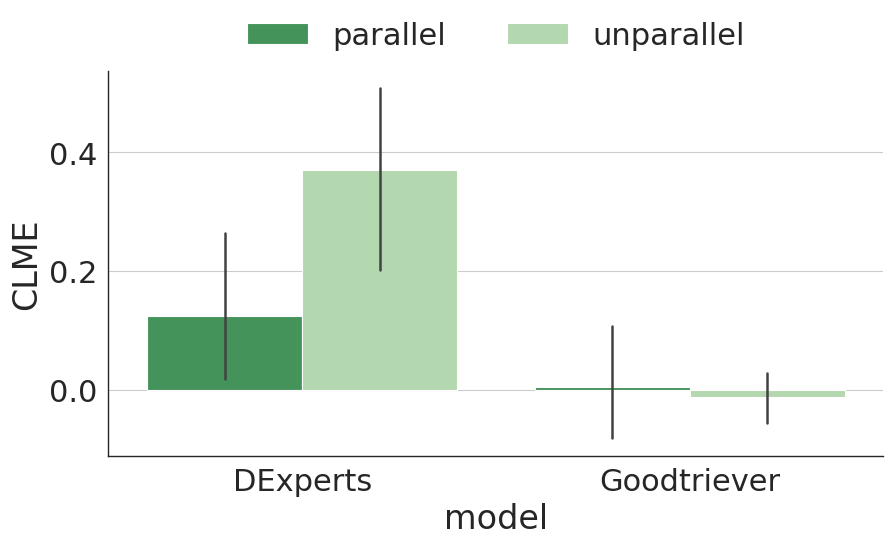

In [26]:
temp = cross_lingual_efct.melt(var_name="model", value_name="CLME")
temp["data regime"] = temp["model"].apply(lambda x: x.split(" ")[-1].strip("()"))
temp["model"] = temp["model"].str.split(" ").str[0]
plt.figure(figsize=(10, 5))
g = sns.barplot(data=temp, x="model", y="CLME", hue="data regime", palette="Greens_r")
g.grid(axis="y")
sns.move_legend(
    g, "upper center", bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=False, title=""
)
sns.despine()
plt.savefig(
    "../images/parallel_vs_unparallel_clme.pdf", format="pdf", bbox_inches="tight"
)
plt.savefig(
    "../images/parallel_vs_unparallel_clme.svg", format="svg", bbox_inches="tight"
)

## Base model size (mid resource)

In [27]:
# Mid resource languages
experiments = {
    "Goodtriever (mGPT 1.3B)": cl_experiments["Goodtriever"]["Translated (mid-res)"],
    "Goodtriever (mGPT 13B)": cl_experiments["Goodtriever"][
        "Translated (mid-res, 13B)"
    ],
}

for name, path in experiments.items():
    assert path.exists(), f"{name} does not exist"

baselines = {
    "mGPT (1.3B)": cl_experiments["mGPT (1.3B)"]["Mid-res"],
    "mGPT (13B)": cl_experiments["mGPT (13B)"]["Mid-res"],
}

metrics_df = get_experiment_results(experiments, include_subfolder=False)
baselines_df = get_experiment_results(baselines, baselines=True, include_subfolder=True)

domains = {
    "ar": "Arabic",
    "ko": "Korean",
    "hi": "Hindi",
    "pt-BR": "Portuguese",
    "ru": "Russian",
    "en": "English",
}

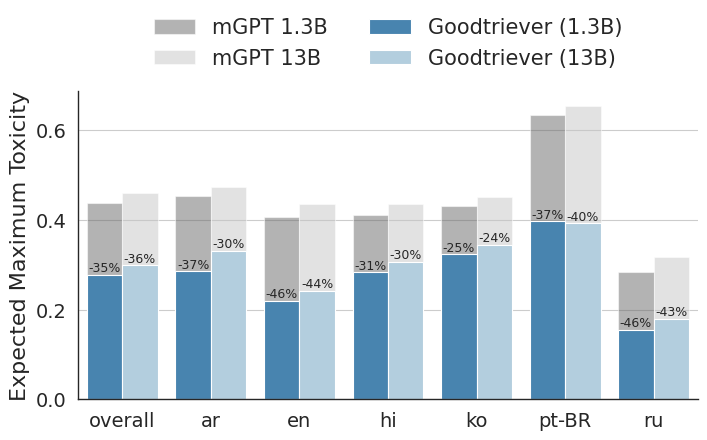

In [28]:
main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"

# Overall
temp_overall = (
    metrics_df["toxicity"]
    .query("domain_idx == 5 and metric in @metric and mode == 'full'")
    .copy()
)
temp_overall["_size"] = temp_overall["experiment"].apply(
    lambda x: "13B" if "13B" in x else "1.3B"
)
temp_overall["size"] = temp_overall["experiment"].apply(
    lambda x: "Goodtriever (13B)" if "13B" in x else "Goodtriever (1.3B)"
)
temp_overall["experiment"] = temp_overall["experiment"].apply(lambda x: x.split(" ")[0])
temp_overall["domain"] = "overall"

base_temp_overall = (
    baselines_df["toxicity"].query("metric == @metric and mode == 'full'").copy()
).copy()
base_temp_overall["_size"] = base_temp_overall["experiment"].apply(
    lambda x: "13B" if "13B" in x else "1.3B"
)
base_temp_overall["size"] = base_temp_overall["experiment"].apply(
    lambda x: "mGPT 13B" if "13B" in x else "mGPT 1.3B"
)
base_temp_overall["experiment"] = base_temp_overall["experiment"].apply(
    lambda x: x.split(" ")[0]
)
base_temp_overall["domain"] = "overall"

# Relative values
groups = temp_overall.groupby(["_size"])
rel_values = pd.Series()
for (_size,), group in groups:
    base_value = base_temp_overall.query("_size == @_size")["value"].iloc[0]
    rel_values = pd.concat(
        [
            rel_values,
            group.apply(lambda x: (x["value"] - base_value) / base_value, axis=1),
        ]
    )
temp_overall.loc[:, "rel_value"] = rel_values.sort_index().values

### Per language
temp = (
    metrics_df[main_metric]
    .query("domain_idx == 5 and metric in @metric and mode == 'full'")
    .reset_index(drop=True)
).copy()
temp["_size"] = temp["experiment"].apply(lambda x: "13B" if "13B" in x else "1.3B")
temp["size"] = temp["experiment"].apply(
    lambda x: "Goodtriever (13B)" if "13B" in x else "Goodtriever (1.3B)"
)
temp["experiment"] = temp["experiment"].apply(lambda x: x.split(" ")[0])

base_temp = (
    baselines_df[main_metric].query("metric == @metric and mode == 'full'").copy()
).copy()
base_temp["_size"] = base_temp["experiment"].apply(
    lambda x: "13B" if "13B" in x else "1.3B"
)
base_temp["size"] = base_temp["experiment"].apply(
    lambda x: "mGPT 13B" if "13B" in x else "mGPT 1.3B"
)
base_temp["experiment"] = base_temp["experiment"].apply(lambda x: x.split(" ")[0])

# Relative values
groups = temp.groupby(["_size", "domain_result"])
rel_values = pd.Series()
for (_size, lang), group in groups:
    base_value = base_temp.query("_size == @_size and domain_result == @lang")[
        "value"
    ].iloc[0]
    rel_values = pd.concat(
        [
            rel_values,
            group.apply(lambda x: (x["value"] - base_value) / base_value, axis=1),
        ]
    )

temp.loc[:, "rel_value"] = rel_values.sort_index().values
temp = pd.concat(
    [pd.DataFrame({"domain_result": ["overall"], "rel_value": 0}, index=[0]), temp]
)

plt.figure(figsize=(8, 4))
g = sns.barplot(
    data=base_temp_overall,
    x="domain",
    y="value",
    hue="size",
    palette="Greys_r",
    alpha=0.5,
)
g = sns.barplot(
    data=temp_overall, x="domain", y="value", hue="size", ax=g, palette="Blues_r"
)

for i, container in enumerate(g.containers[2:]):
    if i == 0:
        vals = temp_overall.query("_size == '1.3B'")
    else:
        vals = temp_overall.query("_size == '13B'")
    vals = vals["rel_value"].apply(lambda x: f"{x:.0%}")
    g.bar_label(container, fontsize=9, labels=vals)

g = sns.barplot(
    data=base_temp,
    x="domain_result",
    y="value",
    hue="size",
    ax=g,
    palette="Greys_r",
    alpha=0.5,
)
g = sns.barplot(
    data=temp, x="domain_result", hue="size", y="value", ax=g, palette="Blues_r"
)

for i, container in enumerate(g.containers[-2:]):
    vals = temp.query("domain_result != 'overall'")
    if i == 0:
        vals = vals.query("_size == '1.3B'")
    else:
        vals = vals.query("_size == '13B'")

    vals = vals.sort_values(by=["domain_result"])["rel_value"].apply(
        lambda x: f"{x:.0%}"
    )
    g.bar_label(container, fontsize=9, labels=vals)

#### Modify legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
sns.move_legend(
    g,
    "upper center",
    ncols=2,
    fontsize=15,
    frameon=False,
    bbox_to_anchor=(0.5, 1.3),
)
sns.despine()
plt.ylabel(metric, fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("")
plt.grid(axis="y")
plt.savefig("../images/13B_emt.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../images/13B_emt.svg", format="svg", bbox_inches="tight")
plt.show()

In [29]:
## RELATIVE plot

main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"
# metric = "Toxicity Probability"
mode = "full"

baseline = baselines_df[main_metric].query("mode == @mode and metric == @metric")
temp = (
    metrics_df[main_metric]
    .query("mode == @mode and metric == @metric")
    .reset_index(drop=True)
)

# Relative values
rel_values = pd.Series()
for experiment in temp.experiment.unique():
    size = experiment.split("(mGPT ")[-1].strip(")")
    groups = temp.query("experiment == @experiment").groupby("domain_result")

    for lang, group in groups:
        base_value = (
            baseline[baseline["experiment"].str.contains(size)]
            .query("domain_result == @lang")["value"]
            .iloc[0]
        )
        rel_values = pd.concat(
            [
                rel_values,
                group.apply(lambda x: (x["value"] - base_value) / base_value, axis=1),
            ]
        )

temp.loc[:, "rel_value"] = rel_values.sort_index().values
temp["Domain"] = temp["domain_result"].map({**domains})

# Add overall curves
overall = (
    metrics_df["toxicity"]
    .query("mode == @mode and metric == @metric")
    .copy()
    .reset_index(drop=True)
)
baseline_overall = (
    baselines_df["toxicity"].query("mode == @mode and metric == @metric").copy()
)
for experiment in temp.experiment.unique():
    size = experiment.split("(mGPT ")[-1].strip(")")
    exp_temp = overall[overall["experiment"].str.contains(size)]
    baseline_val = baseline_overall[baseline_overall["experiment"].str.contains(size)][
        "value"
    ].iloc[0]

    overall.loc[exp_temp.index, "rel_value"] = (
        overall.loc[exp_temp.index, "value"] - baseline_val
    ) / baseline_val
    overall["Domain"] = "Overall"

temp = pd.concat([overall, temp]).reset_index(drop=True)
temp["model_size"] = temp["experiment"].apply(
    lambda x: x.split("(mGPT ")[-1].strip(")")
)

baseline.loc[:, "Domain"] = baseline["domain_result"].map({**domains})
baseline_overall["Domain"] = "Overall"
all_baselines = pd.concat([baseline, baseline_overall])

tables = generate_tables_per_experiment(
    temp, baselines_df=all_baselines, value_col="value", round=2
)

Experiment: Goodtriever (mGPT 1.3B)


/var/tmp/ipykernel_8105/2187256226.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline.loc[:, "Domain"] = baseline["domain_result"].map({**domains})


,language_metric,Overall,Arabic,Korean,Hindi,Portuguese,Russian,English
domain_added,step,,,,,,,
baseline,-1,0.45,0.46,0.44,0.42,0.64,0.30,0.42
arb,0,0.40,0.29,0.43,0.39,0.61,0.27,0.39
kor,1,0.38,0.29,0.33,0.41,0.62,0.27,0.39
hin,2,0.36,0.29,0.32,0.29,0.60,0.28,0.37
por,3,0.33,0.30,0.35,0.29,0.39,0.26,0.40
rus,4,0.30,0.28,0.35,0.28,0.39,0.14,0.37
en,5,0.28,0.29,0.32,0.28,0.40,0.15,0.22


Experiment: Goodtriever (mGPT 13B)


,language_metric,Overall,Arabic,Korean,Hindi,Portuguese,Russian,English
domain_added,step,,,,,,,
baseline,-1,0.45,0.46,0.44,0.42,0.64,0.30,0.42
arb,0,0.43,0.33,0.43,0.40,0.69,0.32,0.41
kor,1,0.37,0.34,0.33,0.40,0.56,0.24,0.34
hin,2,0.37,0.33,0.31,0.30,0.62,0.29,0.38
por,3,0.32,0.33,0.32,0.29,0.40,0.24,0.36
rus,4,0.32,0.34,0.33,0.31,0.40,0.18,0.39
en,5,0.30,0.33,0.34,0.31,0.39,0.18,0.24


In [30]:
temp2 = temp.query("domain_idx == 5").copy()

temp2.groupby("model_size")["rel_value"].mean()

model_size
1.3B   -0.369162
13B    -0.350921
Name: rel_value, dtype: float64

In [31]:
# Cross lingual transfer: avg mitigation on languages not added at that timestep
cross_lingual_efct = dict()
for name, table in tables.items():
    cross_lingual_efct[name] = (
        table.rolling(2)
        .apply(lambda x: x[0] - x[1])
        .drop("Overall", axis=1)
        .apply(lambda x: (x.sum() - x[x.name[1]]).mean(), axis=1)
    )

cross_lingual_efct = pd.DataFrame(cross_lingual_efct).round(3).dropna()
cross_lingual_efct

,,Goodtriever (mGPT 1.3B),Goodtriever (mGPT 13B)
domain_added,step,,
arb,0,0.13,-0.03
kor,1,-0.03,0.27
hin,2,0.04,-0.12
por,3,-0.05,0.07
rus,4,0.06,-0.07
en,5,0.00,0.01


## Translation quality - single language

In [32]:
experiments = {
    "Portuguese": cl_experiments["Translation Quality"]["Portuguese"],
    "Russian": cl_experiments["Translation Quality"]["Russian"],
    "Hindi": cl_experiments["Translation Quality"]["Hindi"],
    "Arabic": cl_experiments["Translation Quality"]["Arabic"],
}

for name, path in experiments.items():
    assert path.exists(), f"{name} does not exist"

metrics_df = get_experiment_results(experiments, include_subfolder=True, baselines=True)

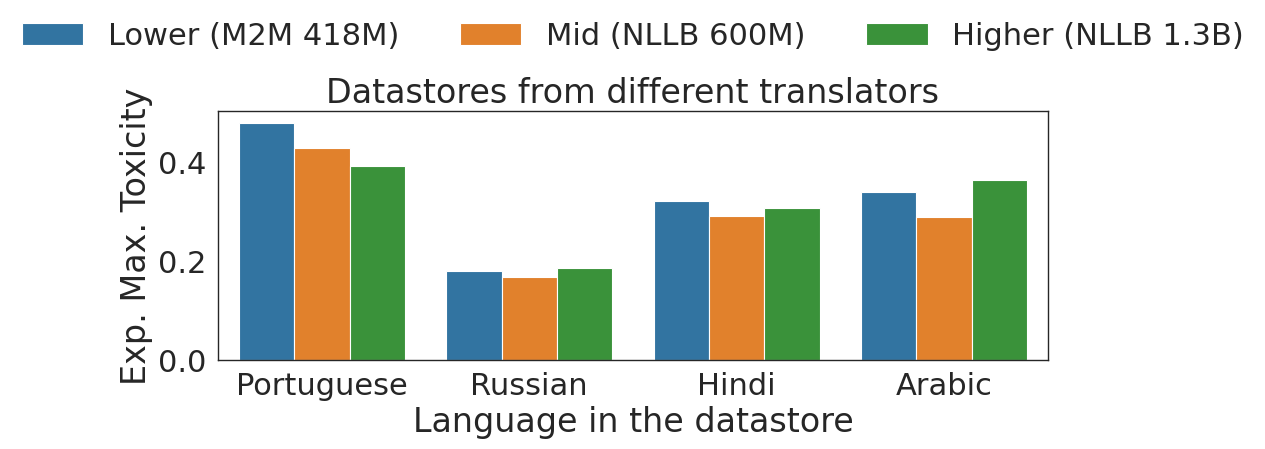

In [33]:
metric = "Expected Maximum Toxicity"
not_subfolder = ["recompute_dists", "nllb_600_recompute_dists"]
temp = (
    metrics_df["toxicity"]
    .query("mode == 'full' and metric == @metric and subfolder not in @not_subfolder")
    .copy()
)
temp["experiment"] = temp["experiment"].str.split("_").str[0]
temp["translation quality"] = temp["subfolder"].map(
    {
        "portuguese": "Mid (NLLB 600M)",
        "russian": "Mid (NLLB 600M)",
        "hindi": "Mid (NLLB 600M)",
        "arabic": "Mid (NLLB 600M)",
        "nllb_1.3": "Higher (NLLB 1.3B)",
        "m2m_418": "Lower (M2M 418M)",
    }
)

plt.figure(figsize=(10, 4))
g = sns.barplot(
    data=temp,
    x="experiment",
    y="value",
    hue="translation quality",
    hue_order=["Lower (M2M 418M)", "Mid (NLLB 600M)", "Higher (NLLB 1.3B)"],
)
plt.tight_layout()
sns.move_legend(g, "center", bbox_to_anchor=(0.5, 1.3), frameon=False, ncol=3, title="")
g.set_ylabel("Exp. Max. Toxicity")
g.set_xlabel("Language in the datastore")
g.set_title("Datastores from different translators")
plt.savefig("../images/translation_quality.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../images/translation_quality.svg", format="svg", bbox_inches="tight")

## Datastore size

In [34]:
language = "pt"
model = "goodtriever"

experiment_folder = results_folder / f"datastore_size/{language}/{model}"
assert experiment_folder.exists()

metrics = ["perplexity", "diversity", "toxicity"]

metrics_dfs = {}
partition = "full"  # metric partition
for metric in metrics:
    files = list(experiment_folder.rglob(f"*{metric}.csv"))
    metric_df = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file, index_col=0)
        param_series = pd.DataFrame(
            dict([sec.split("=") for sec in file.parent.stem.split("_")]),
            index=[file.parent.stem],
        )

        if metric == "toxicity":
            df = df[partition]
            df.name = file.parent.stem
            df = df.to_frame().T.rename(
                columns={
                    "avg_max": "Expected Maximum Toxicity",
                    "toxicity_probability": "Toxicity Probability",
                }
            )
            df["partition"] = partition

        if metric == "perplexity":
            df = df.rename(
                columns={partition: "perplexity"},
                index={"perplexity": file.parent.stem},
            )

        if metric == "diversity":
            df = df.rename(index={0: file.parent.stem})

        df = pd.concat([param_series, df], axis=1)
        metric_df = pd.concat([metric_df, df.reset_index()])

    metrics_dfs[metric] = metric_df.reset_index(drop=True)

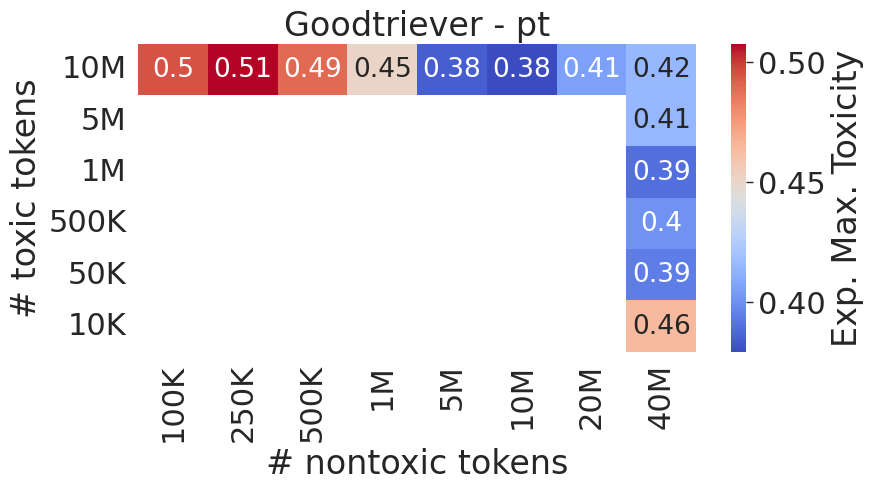

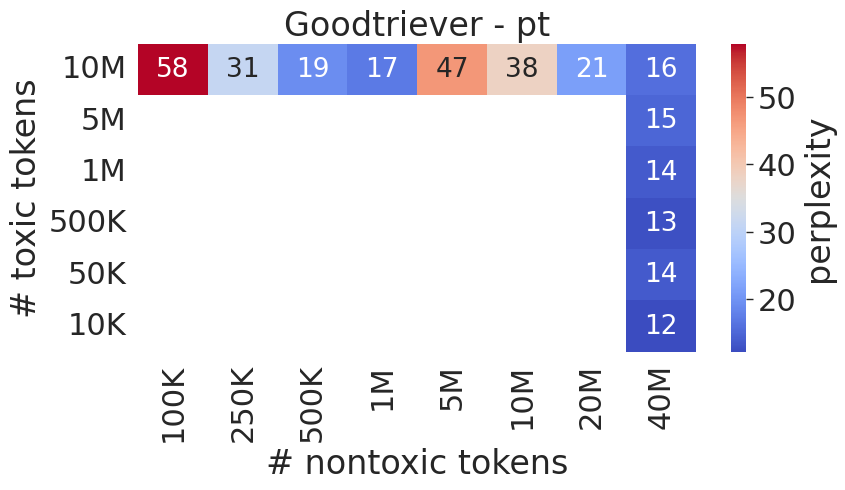

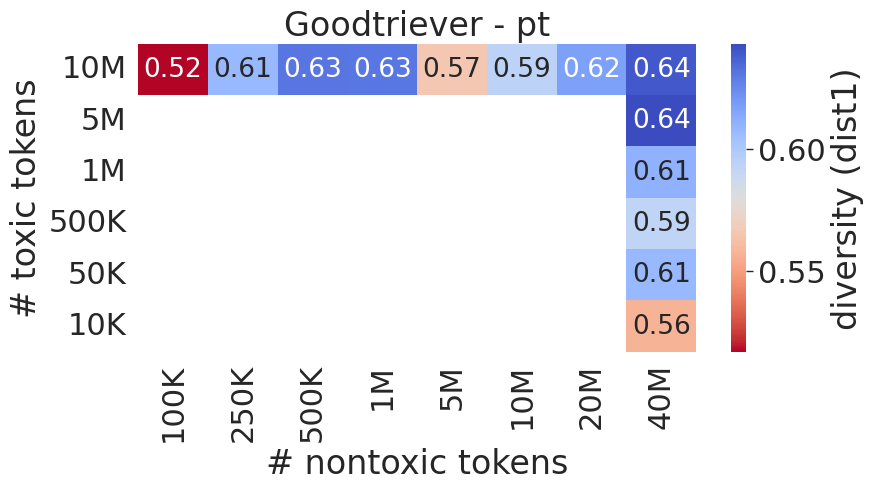

In [35]:
metric = "Expected Maximum Toxicity"
temp = metrics_dfs["toxicity"].copy()

model_name = {
    "goodtriever": "Goodtriever",
    "dexperts": "DExperts",
}

# TODO the number of maximum tokens change from language to language
temp["toxic"] = temp["toxic"].replace({"None": 10000000}).astype(int)
temp["nontoxic"] = temp["nontoxic"].replace({"None": 50000000}).astype(int)

vary_nontoxic = temp.query("toxic == 10000000").copy().sort_values("nontoxic")
vary_toxic = temp.query("nontoxic == 50000000").copy().sort_values("toxic")

temp = pd.pivot_table(
    temp[["toxic", "nontoxic", metric]],
    values=[metric],
    index="toxic",
    columns=["nontoxic"],
).droplevel(
    0, axis=1
)  # .drop([10000, 50000], axis=1)

plt.figure(figsize=(9, 4))
sns.heatmap(
    temp[::-1],
    annot=True,
    cmap="coolwarm",
    cbar_kws={"label": "Exp. Max. Toxicity"},
    annot_kws={"fontsize": 19},
)
plt.xlabel("# nontoxic tokens")
plt.ylabel("# toxic tokens")
plt.xticks(
    ticks=plt.xticks()[0],
    labels=["100K", "250K", "500K", "1M", "5M", "10M", "20M", "40M"],
    rotation=90,
)
plt.yticks(
    ticks=plt.yticks()[0], labels=["10K", "50K", "500K", "1M", "5M", "10M"][::-1]
)
plt.title(f"{model_name[model]} - {language}")
plt.savefig(
    f"../images/exp_ds_size_{model}_{metric.lower().replace(' ', '_')}_heatmap.pdf",
    bbox_inches="tight",
)
plt.savefig(
    f"../images/exp_ds_size_{model}_{metric.lower().replace(' ', '_')}_heatmap.svg",
    format="svg",
    bbox_inches="tight",
)
plt.show()

metric = "perplexity"
temp = metrics_dfs[metric].copy()
temp.columns = ["index", "toxic", "nontoxic", "perplexity"]  # quick fix

temp = pd.pivot_table(
    temp[["toxic", "nontoxic", metric]],
    values=[metric],
    index="toxic",
    columns=["nontoxic"],
).droplevel(0, axis=1)

plt.figure(figsize=(9, 4))
sns.heatmap(
    temp[::-1],
    annot=True,
    cmap="coolwarm",
    cbar_kws={"label": metric},
    annot_kws={"fontsize": 19},
)
plt.xlabel("# nontoxic tokens")
plt.ylabel("# toxic tokens")
plt.xticks(
    ticks=plt.xticks()[0],
    labels=["100K", "250K", "500K", "1M", "5M", "10M", "20M", "40M"],
    rotation=90,
)
plt.yticks(
    ticks=plt.yticks()[0], labels=["10K", "50K", "500K", "1M", "5M", "10M"][::-1]
)
plt.title(f"{model_name[model]} - {language}")
plt.savefig(
    f"../images/exp_ds_size_{model}_{metric.lower().replace(' ', '_')}_heatmap.pdf",
    bbox_inches="tight",
)
plt.savefig(
    f"../images/exp_ds_size_{model}_{metric.lower().replace(' ', '_')}_heatmap.svg",
    format="svg",
    bbox_inches="tight",
)
plt.show()

metric = "dist1"
temp = metrics_dfs["diversity"].copy()
# temp.columns = ["index", "toxic", "nontoxic", "diversity"] # quick fix

temp = pd.pivot_table(
    temp[["toxic", "nontoxic", metric]],
    values=[metric],
    index="toxic",
    columns=["nontoxic"],
).droplevel(0, axis=1)

plt.figure(figsize=(9, 4))
sns.heatmap(
    temp[::-1],
    annot=True,
    cmap="coolwarm_r",
    cbar_kws={"label": f"diversity ({metric})"},
    annot_kws={"fontsize": 19},
)
plt.xlabel("# nontoxic tokens")
plt.ylabel("# toxic tokens")
plt.xticks(
    ticks=plt.xticks()[0],
    labels=["100K", "250K", "500K", "1M", "5M", "10M", "20M", "40M"],
    rotation=90,
)
plt.yticks(
    ticks=plt.yticks()[0], labels=["10K", "50K", "500K", "1M", "5M", "10M"][::-1]
)
plt.title(f"{model_name[model]} - {language}")
plt.savefig(
    f"../images/exp_ds_size_{model}_{metric.lower().replace(' ', '_')}_heatmap.pdf",
    bbox_inches="tight",
)
plt.savefig(
    f"../images/exp_ds_size_{model}_{metric.lower().replace(' ', '_')}_heatmap.svg",
    format="svg",
    bbox_inches="tight",
)
plt.show()